In [ ]:
import jax, jax.numpy as jnp
import numpy as np
import flax, flax.linen as nn

jax_key = jax.random.PRNGKey(0)
BATCH_SIZE=4
CTX_LEN=8

## Dataset loading
Downloading Dataset

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

--2023-08-02 06:14:38--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2023-08-02 06:14:39 (31.0 MB/s) - ‘input.txt’ saved [1115394/1115394]

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 100 characters
print(text[:100])

## Tokenizers

Select one

### Character level tokenizer

Show all possible tokens to be stored

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


Simple encoder and decoder for tokenizer

In [ ]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }  # string -> int
itos = { i:ch for i,ch in enumerate(chars) }  # int -> str

def tokenize(text):
  return np.array([stoi[c] for c in text])

def detokenize(arr):
  return ''.join([itos[i] for i in arr])


In [ ]:
print(tokenize("geeks. gamers. geek and gamer culture"))
print(detokenize(tokenize("hello world")))

[45 43 43 49 57  8  1 45 39 51 43 56 57  8  1 45 43 43 49  1 39 52 42  1
 45 39 51 43 56  1 41 59 50 58 59 56 43]
hello world


## Dataset splitting

In [ ]:
dataset = jnp.array(tokenize(text))
print(dataset.shape, dataset.dtype)

(1115394,) int32


In [ ]:
# test if this is jittable
# @jax.jit
def get_batch(X):
  """
  Pulls a random batch from a given dataset, X
  """
  N = X.shape[0]
  offset = jax.random.randint(jax_key, (1,), 0, N-(BATCH_SIZE*CTX_LEN+1))
  i = jnp.arange(BATCH_SIZE*(CTX_LEN+1)) + offset

  res = X.at[i].get().reshape(BATCH_SIZE, CTX_LEN+1)

  # input, targets (shifted by 1)
  return res.at[:, :CTX_LEN].get(), res.at[:, 1:CTX_LEN+1].get()

get_batch(dataset)

(Array([[53,  6,  1, 61, 46, 53,  6,  1],
        [39, 42,  1, 46, 43,  1, 46, 47],
        [57, 43, 50, 44,  0, 43, 58, 43],
        [52, 47, 58, 63,  1, 39, 52, 42]], dtype=int32),
 Array([[ 6,  1, 61, 46, 53,  6,  1, 46],
        [42,  1, 46, 43,  1, 46, 47, 51],
        [43, 50, 44,  0, 43, 58, 43, 56],
        [47, 58, 63,  1, 39, 52, 42,  1]], dtype=int32))

## Transformer!
building blocks of a transformer
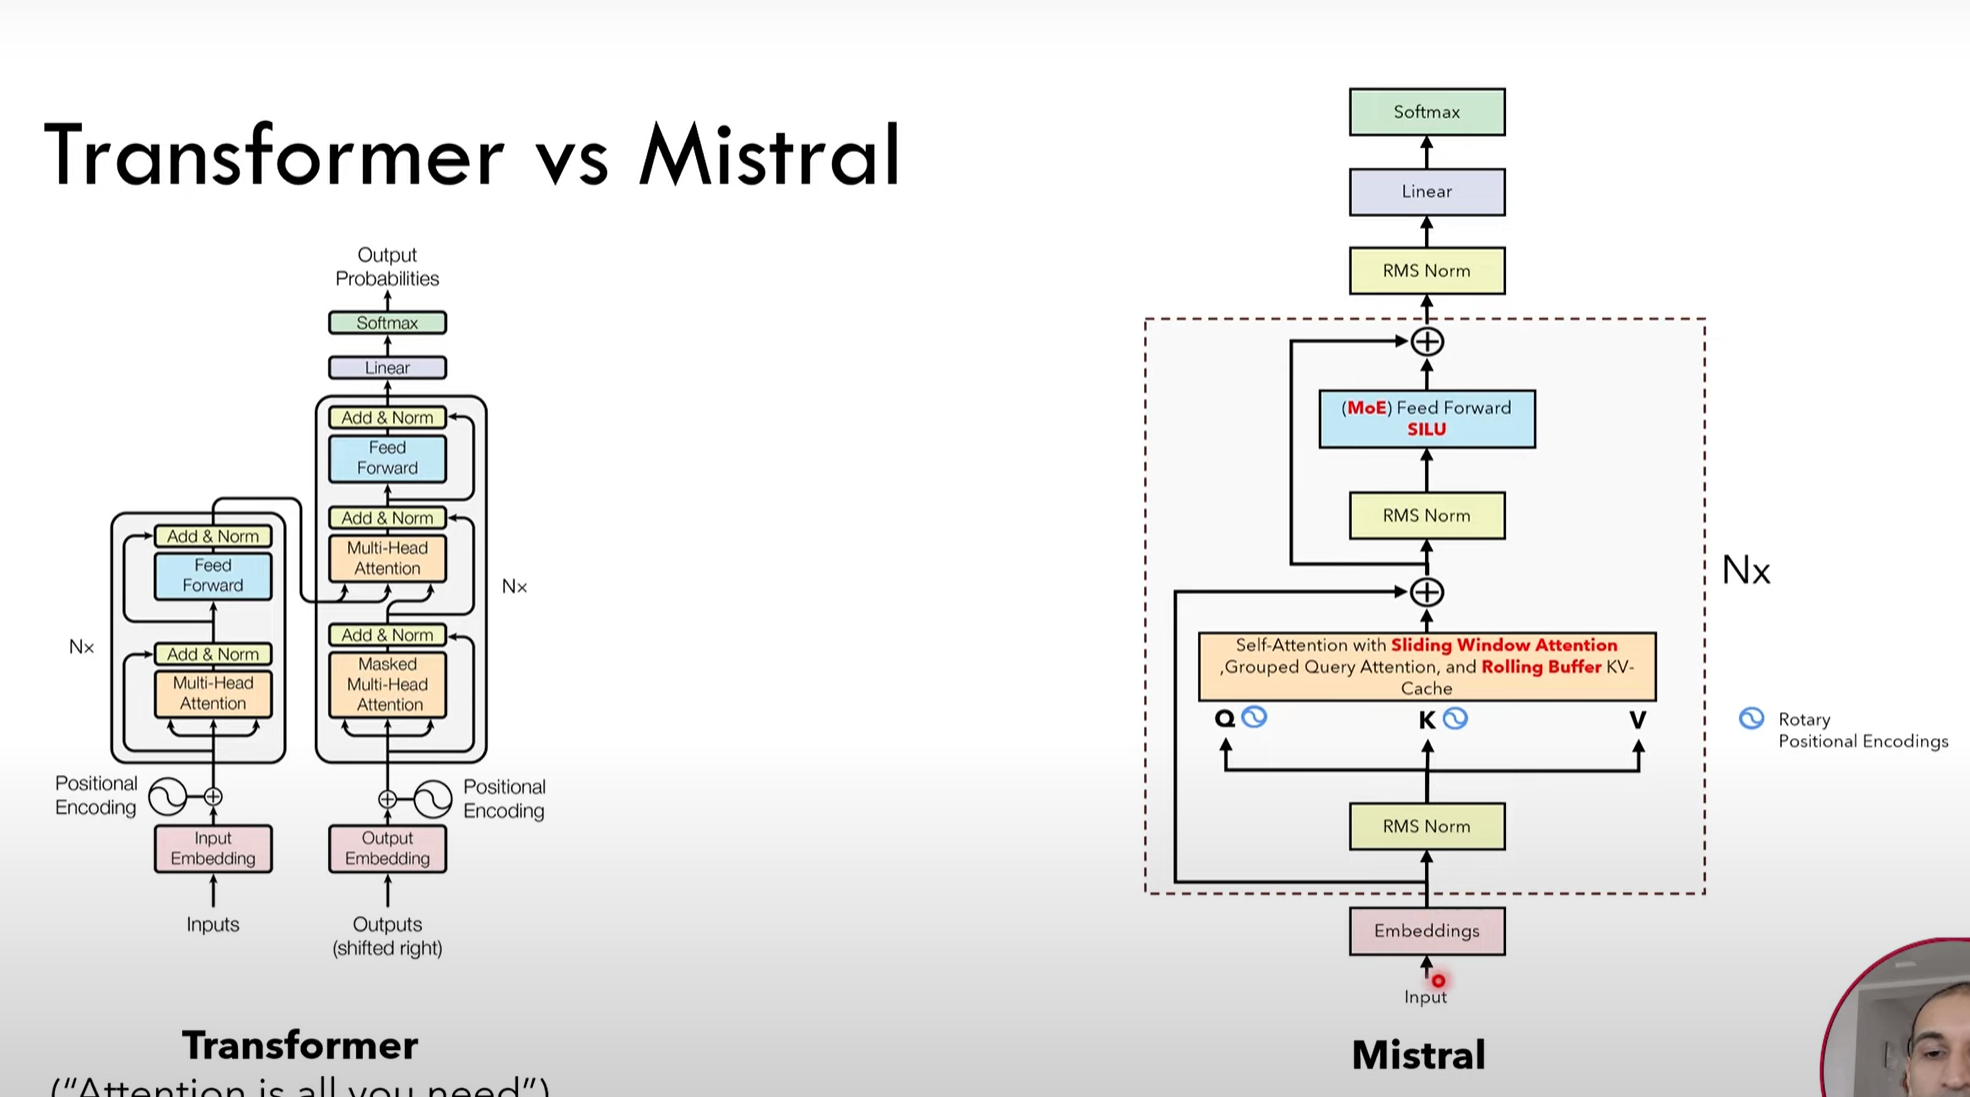

**Making all the building blocks of a transformer + a more modern model**

### Multi-head attention

In [ ]:
class MHA(nn.Module):
  num_hiddens: int
  num_heads: int
  bias: bool = False

  def setup(self):
    self.W_q = nn.Dense(self.num_hiddens*self.num_heads, use_bias=self.bias)
    self.W_k = nn.Dense(self.num_hiddens*self.num_heads, use_bias=self.bias)
    self.W_v = nn.Dense(self.num_hiddens*self.num_heads, use_bias=self.bias)
    self.W_o = nn.Dense(self.num_hiddens, use_bias=self.bias)

    # vectorize along head dimension
    # self.mha_dp_atn = jax.vmap(self.dotprod_atn, (1, 1, 1), 1)
    self.batch_softmax = jax.vmap(self.softmax, (0,), 0)

  def softmax(self, z):
    """
    Computes softmax along every row in a 2D matrix
    """
    zmax = jnp.max(z, axis=1)
    z = jnp.exp(z - zmax)
    scores = z / jnp.sum(z, axis=1)

  @nn.compact
  def __call__(self, Q, K, V):

    # Batch, time, embedding dimension
    B,T,D = Q.shape

    # compute QKV for each head in parallel
    Q = self.W_q(Q).reshape((B, self.num_heads, T, self.num_hiddens))
    K = self.W_k(K).reshape((B, self.num_heads, self.num_hiddens, T))
    V = self.W_v(V).reshape((B, self.num_heads, T, self.num_hiddens))

    sim = Q @ K
    c = self.batch_softmax(jnp.ones((B, T, T)))

    # reweigh V for each head, flatten

    return c

mha = MHA(12, 2)

# dummy input with batch, time, embedding dimension
X_ex = jnp.ones((BATCH_SIZE, CTX_LEN, 3))

# retrieve model state WRT self attention
# initialize parameters to dummy input shape for testing
params = mha.init(jax_key, X_ex, X_ex, X_ex)
print(mha.apply(params, X_ex, X_ex, X_ex).shape)
print(mha.tabulate(jax_key, X_ex, X_ex, X_ex))


AttributeError: 'NoneType' object has no attribute 'shape'

### Decoder Block

Don't need an encoder, because we are generating text only, not conditioning on something

In [ ]:
class EncBlock(nn.module):
  num_hiddens: int
  num_heads: int
  bias: bool = False

  def setup(self):
    self.atn = MHA(num_hiddens, num_heads, bias)
    self.ff = nn.Dense(num_hiddens)

  def __call__(self, X):
    B, T, D = X.shape  # batch, time, embeddings
    atn_out = self.atn(X, X, X)


## Bigram baseline model (for fun)